In [8]:
import numpy as np
import matplotlib.pyplot as plt

def Lorenz63(state,*args): #Lorenz 63 model
    sigma = args[0]
    beta = args[1]
    rho = args[2]
    x, y, z = state #Unpack the state vector
    f = np.zeros(3) #Derivatives
    f[0] = sigma * (y - x)
    f[1] = x * (rho - z) - y
    f[2] = x * y - beta * z
    return f 

def RK4(rhs,state,dt,*args):
    
    k1 = rhs(state,*args)
    k2 = rhs(state+k1*dt/2,*args)
    k3 = rhs(state+k2*dt/2,*args)
    k4 = rhs(state+k3*dt,*args)

    new_state = state + (dt/6)*(k1+2*k2+2*k3+k4)
    return new_state

def EnKF(ubi,w,ObsOp,JObsOp,R,B):
    
    # The analysis step for the (stochastic) ensemble Kalman filter 
    # with virtual observations

    n,N = ubi.shape # n is the state dimension and N is the size of ensemble
    m = w.shape[0] # m is the size of measurement vector

    # compute the mean of forecast ensemble
    ub = np.mean(ubi,1)    
    # evaluate Jacobian of observation operator at ub
    Dh = JObsOp(ub)
    # compute Kalman gain
    D = Dh@B@Dh.T + R
    K = B @ Dh.T @ np.linalg.inv(D)
        
    
    wi = np.zeros([m,N])
    uai = np.zeros([n,N])
    for i in range(N):
        # create virtual observations
        wi[:,i] = w + np.random.multivariate_normal(np.zeros(m), R)
        # compute analysis ensemble
        uai[:,i] = ubi[:,i] + K @ (wi[:,i]-ObsOp(ubi[:,i]))
        
    # compute the mean of analysis ensemble
    ua = np.mean(uai,1)    
    # compute analysis error covariance matrix
    P = (1/(N-1)) * (uai - ua.reshape(-1,1)) @ (uai - ua.reshape(-1,1)).T
    return uai, P

## Parameters

In [9]:
sigma = 10.0     
beta = 8.0/3.0
rho = 28.0     
dt = 0.01
tm = 10
nt = int(tm/dt)
t = np.linspace(0,tm,nt+1)

## Twin experiment

In [10]:
def h(u):
    w = u
    return w

def Dh(u):
    n = len(u)
    D = np.eye(n)
    return D


u0True = np.array([1,1,1]) # True initial conditions
np.random.seed(seed=1)
sig_m= 0.15  # standard deviation for measurement noise
R = sig_m**2*np.eye(3) #covariance matrix for measurement noise

dt_m = 0.2 #time period between observations
tm_m = 2 #maximum time for observations
nt_m = int(tm_m/dt_m) #number of observation instants

ind_m = (np.linspace(int(dt_m/dt),int(tm_m/dt),nt_m)).astype(int)
t_m = t[ind_m]

#time integration
uTrue = np.zeros([3,nt+1])
uTrue[:,0] = u0True
km = 0
w = np.zeros([3,nt_m])
for k in range(nt):
    uTrue[:,k+1] = RK4(Lorenz63,uTrue[:,k],dt,sigma,beta,rho)
    if (km<nt_m) and (k+1==ind_m[km]):
        w[:,km] = h(uTrue[:,k+1]) + np.random.normal(0,sig_m,[3,])
        km = km+1

## DA

In [11]:
u0b = np.array([2.0,3.0,4.0])

sig_b= 0.1
B = sig_b**2*np.eye(3)
Q = 0.0*np.eye(3)

#time integration
ub = np.zeros([3,nt+1])
ub[:,0] = u0b
ua = np.zeros([3,nt+1])
ua[:,0] = u0b

n = 3 #state dimension
m = 3 #measurement dimension

# ensemble size 
N = 10
#initialize ensemble
uai = np.zeros([3,N])
for i in range(N):
    uai[:,i] = u0b + np.random.multivariate_normal(np.zeros(n), B)

km = 0
for k in range(nt):
    # Forecast Step
    #background trajectory [without correction]
    ub[:,k+1] = RK4(Lorenz63,ub[:,k],dt,sigma,beta,rho) 
    #EnKF trajectory [with correction at observation times]
    for i in range(N): # forecast ensemble
        uai[:,i] = RK4(Lorenz63,uai[:,i],dt,sigma,beta,rho) \
                 + np.random.multivariate_normal(np.zeros(n), Q)

    # compute the mean of forecast ensemble
    ua[:,k+1] = np.mean(uai,1)
    # compute forecast error covariance matrix
    B = (1/(N-1)) * (uai - ua[:,k+1].reshape(-1,1)) @ (uai - ua[:,k+1].reshape(-1,1)).T

    if (km<nt_m) and (k+1==ind_m[km]):
        # Analysis Step
        uai,B = EnKF(uai,w[:,km],h,Dh,R,B)
        # compute the mean of analysis ensemble
        ua[:,k+1] = np.mean(uai,1)    
        km = km+1

## Output

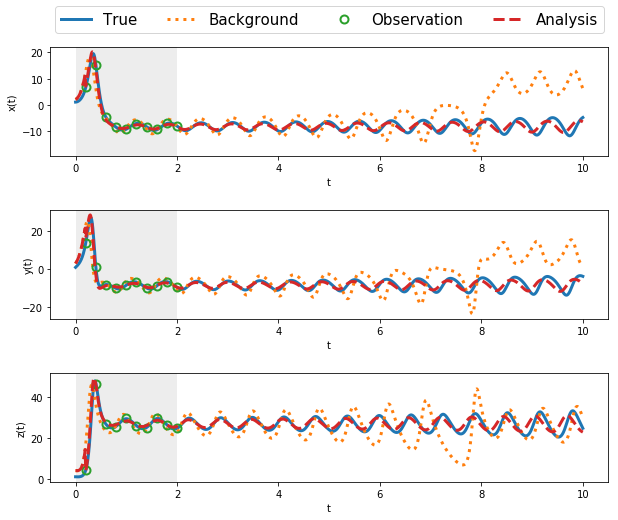

In [14]:
fig, ax = plt.subplots(nrows=3,ncols=1, figsize=(10,8))
ax = ax.flat

for k in range(3):
    ax[k].plot(t,uTrue[k,:], label='True', linewidth = 3)
    ax[k].plot(t,ub[k,:], ':', label='Background', linewidth = 3)
    ax[k].plot(t[ind_m],w[k,:], 'o', fillstyle='none', \
               label='Observation', markersize = 8, markeredgewidth = 2)
    ax[k].plot(t,ua[k,:], '--', label='Analysis', linewidth = 3)
    ax[k].set_xlabel('t')
    ax[k].axvspan(0, tm_m, color='lightgray', alpha=0.4, lw=0)

ax[0].legend(loc="center", bbox_to_anchor=(0.5,1.25),ncol =4,fontsize=15)

ax[0].set_ylabel('x(t)', labelpad=5)
ax[1].set_ylabel('y(t)', labelpad=-12)
ax[2].set_ylabel('z(t)')
fig.subplots_adjust(hspace=0.5)

plt.savefig('L63_EnKF.eps', dpi = 500, bbox_inches = 'tight')